# Lab 4 - Aspect-Based Sentiment Analysis



---















In this session, we demonstrate how to deal with the aspect-based sentiment analysis (ABSA). You can find the whole task description from (https://aclanthology.org/D19-1654.pdf).
This task provides a review text dataset with aspect.
Given a review and an aspect, we need to classify the sentiment conveyed towards that aspect on a  three-point scale:   POSITIVE, NEUTRAL, and NEGATIVE.
This is a multi-class classification task, and it needs to analyze the text and its aspect. 

Same as before, we are going to use Keras Sequential API in this session. The Sequential API allows you to make models layer-by-layer. You could modify the previous models to fit in the new task.

In [ ]:
import keras
import numpy as np
from keras.layers import Lambda, GlobalAveragePooling1D, Dense, Embedding
from keras import backend as K
from keras.models import Sequential
import matplotlib.pyplot as plt

from keras.layers import LSTM, RNN, Dropout, Input, LeakyReLU, Bidirectional,Conv1D, GlobalMaxPooling1D
from keras.layers.core import Dense
from keras.models import Model
import tensorflow as tf
import copy

### Downloading and preprocessing data

Unlike the IMDB dataset that is included and preprocessed by the Keras, the dataset we will be using is the aspect-term sentiment analysis (ATSA) dataset, which consists of 5297 labeled reviews. These are split into 4,297 reviews for training and 500 reviews for testing and validation, respectively. 

For ATSA, the annotators extract aspect terms in the sentences and label the sentiment polarities with respect to the  aspect  terms.   The  sentences  that  consist  of only one aspect term or multiple aspects with the same  sentiment  polarities  are  deleted.  ATSA also provides the start and end positions in a sentence for each aspect term.

In [ ]:
import requests
def downloadfile(url):
  rq = requests.get(url)
  open(url.split('/')[-1], 'wb').write(rq.content)
downloadfile('https://raw.githubusercontent.com/siat-nlp/MAMS-for-ABSA/master/data/MAMS-ATSA/raw/train.xml')
downloadfile('https://raw.githubusercontent.com/siat-nlp/MAMS-for-ABSA/master/data/MAMS-ATSA/raw/val.xml')
downloadfile('https://raw.githubusercontent.com/siat-nlp/MAMS-for-ABSA/master/data/MAMS-ATSA/raw/test.xml')


In [ ]:
from numpy.random import seed
seed(1)

In [ ]:
# The code is modified from https://raw.githubusercontent.com/siat-nlp/MAMS-for-ABSA/master/data_process/utils.py
from xml.etree.ElementTree import parse

def parse_sentence_term(path, lowercase=False):
    tree = parse(path)
    sentences = tree.getroot()
    data = []
    split_char = '__split__'
    for sentence in sentences:
        text = sentence.find('text')
        if text is None:
            continue
        text = text.text
        if lowercase:
            text = text.lower()
        aspectTerms = sentence.find('aspectTerms')
        if aspectTerms is None:
            continue
        for aspectTerm in aspectTerms:
            term = aspectTerm.get('term')
            if lowercase:
                term = term.lower()
            polarity = aspectTerm.get('polarity')
            start = aspectTerm.get('from')
            end = aspectTerm.get('to')
            piece = [text , term,  polarity , start , end]
            data.append(piece)
    return data
train = parse_sentence_term("train.xml",True)
val = parse_sentence_term("val.xml",True)
test = parse_sentence_term("test.xml",True)

print("Training entries: {}".format(len(train)))
print("Test entries: {}".format(len(test)))

Training entries: 11186
Test entries: 1336


We now can start playing around with the data, let’s first see some examples:

In [ ]:
print("SENTENCE \t ASPECT \t LABEL \t ASPECT-START-INDEX \t ASPECT-END-INDEX")
print(train[0])
print(train[1])
print(train[2])
print(train[3])
print(train[4])

SENTENCE 	 ASPECT 	 LABEL 	 ASPECT-START-INDEX 	 ASPECT-END-INDEX
['the decor is not special at all but their food and amazing prices make up for it.', 'decor', 'negative', '4', '9']
['the decor is not special at all but their food and amazing prices make up for it.', 'food', 'positive', '42', '46']
['the decor is not special at all but their food and amazing prices make up for it.', 'prices', 'positive', '59', '65']
['when tables opened up, the manager sat another party before us.', 'tables', 'neutral', '5', '11']
['when tables opened up, the manager sat another party before us.', 'manager', 'negative', '27', '34']


We could use this dataset to try an "unknown aspect" task, if we assume that the ASPECT, LABEL and START/END-INDEX fields are what the model must predict. But here we will attempt a simpler "known aspect" task: we will assume that we know ASPECT and START/END-INDEX and the model must just predict the LABEL for a given combination of aspect and sentence.

First, build a vocabulary based on the training dataset. 

In [ ]:
voc = []
from keras.preprocessing.text import text_to_word_sequence
for example in train:
  text_tokens = text_to_word_sequence(example[0])
  aspect_tokens = text_to_word_sequence(example[1])
  voc.extend(aspect_tokens)
  voc.extend(text_tokens)
voc = set(voc)
print(len(voc))

word_index = dict()
word_index["<PAD>"] = 0
word_index["<START>"] = 1
word_index["<UNK>"] = 2  
word_index["<EOS>"] = 3
for w in voc:
  word_index[w] = len(word_index)
print(len(word_index))

7894
7898


According to the word_index and the tokenizer function (text_to_word_sequence), we can convert the review text and aspect words to word tokens and integers separately:


In [ ]:
import tensorflow as tf
x_train_review=[] 
i=0
for i in range(len(train)):
  x_train_review.append(tf.keras.preprocessing.text.text_to_word_sequence(train[i][0])) #extracting only review from train data

x_train_aspect=[]
i=0
for i in range(len(train)):
  x_train_aspect.append(tf.keras.preprocessing.text.text_to_word_sequence(train[i][1])) #extracting only aspect from train data

x_train_review_int= copy.deepcopy(x_train_review)

for list1 in x_train_review_int:
  for i in list1:
    index = list1.index(i) #get each word index for only train review
    list1[index]=word_index.get(i)  #then replace each word with it's respective int number from word_index 

x_train_aspect_int= copy.deepcopy(x_train_aspect)

for list1 in x_train_aspect_int:
  for i in list1:
    index = list1.index(i) #get each word index for only train aspect
    list1[index]=word_index.get(i) #then replace each word with it's respective int number from word_index 

In [ ]:
x_dev_review=[]
i=0
for i in range(len(val)):
  x_dev_review.append(tf.keras.preprocessing.text.text_to_word_sequence(val[i][0]))

x_dev_aspect=[]
i=0
for i in range(len(val)):
  x_dev_aspect.append(tf.keras.preprocessing.text.text_to_word_sequence(val[i][1]))

x_dev_review_int= copy.deepcopy(x_dev_review)

for list1 in x_dev_review_int:
  for i in list1:
    if i in word_index.keys():
      index = list1.index(i)
      list1[index]=word_index.get(i) 
    else:
      index = list1.index(i)
      list1[index]='<UNK>' #if it's an unknown word and not present in word_index dictionary than replace it with <UNK>
      list1[index]=word_index.get(list1[index]) 


x_dev_aspect_int= copy.deepcopy(x_dev_aspect)

for list1 in x_dev_aspect_int:
  for i in list1:
    if i in word_index.keys():
      index = list1.index(i)
      list1[index]=word_index.get(i) 
    else:
      index = list1.index(i)
      list1[index]='<UNK>'
      list1[index]=word_index.get(list1[index]) 

In [ ]:
x_test_review=[]
i=0
for i in range(len(test)):
  x_test_review.append(tf.keras.preprocessing.text.text_to_word_sequence(test[i][0]))

x_test_aspect=[]
i=0
for i in range(len(test)):
  x_test_aspect.append(tf.keras.preprocessing.text.text_to_word_sequence(test[i][1]))

x_test_review_int= copy.deepcopy(x_test_review)

for list1 in x_test_review_int:
  for i in list1:
    if i in word_index.keys():
      index = list1.index(i)
      list1[index]=word_index.get(i) 
    else:
      index = list1.index(i)
      list1[index]='<UNK>'
      list1[index]=word_index.get(list1[index]) 


x_test_aspect_int= copy.deepcopy(x_test_aspect)

for list1 in x_test_aspect_int:
  for i in list1:
    if i in word_index.keys():
      index = list1.index(i)
      list1[index]=word_index.get(i) 
    else:
      index = list1.index(i)
      list1[index]='<UNK>'
      list1[index]=word_index.get(list1[index]) 

In [ ]:
# If use the previous word_index, you can get a print result like:
assert len(x_train_aspect) == len(train)
assert len(x_train_aspect) == len(x_train_aspect_int)
assert len(x_test_aspect) == len(test)
assert len(x_test_aspect) == len(x_test_aspect_int)
print("x_train_review[0]:")
print(x_train_review[0])
print("x_train_aspect[0]:")
print(x_train_aspect[0])
print("x_train_review_int[0]:")
print(x_train_review_int[0])
print("x_train_aspect_int[0]:")
print(x_train_aspect_int[0])

x_train_review[0]:
['the', 'decor', 'is', 'not', 'special', 'at', 'all', 'but', 'their', 'food', 'and', 'amazing', 'prices', 'make', 'up', 'for', 'it']
x_train_aspect[0]:
['decor']
x_train_review_int[0]:
[4766, 1533, 7783, 1468, 1161, 7607, 226, 6464, 7883, 2839, 58, 4070, 418, 6191, 5215, 902, 7766]
x_train_aspect_int[0]:
[1533]


We use 4 to represent "positive", 2 for "neutral", and 1 for "negative". Then we can convert the lables to numbers.

In [ ]:
def label2int(dataset):
  y = []
  for example in dataset:
    if example[2].lower() == "negative":
      y.append([0,0,1])
    elif example[2].lower() == "neutral":
      y.append([0,1,0])
    else:
      # assert example[2].lower() == "positive"
      y.append([1,0,0])
  return y
  
y_train = label2int(train)
y_dev = label2int(val)
y_test = label2int(test)
y_train = np.array(y_train)
y_dev = np.array(y_dev)
y_test = np.array(y_test)

print(y_train[0])
print(y_train[1])
print(y_train[2])
print(y_train[3])
print(y_train[4])

[0 0 1]
[1 0 0]
[1 0 0]
[0 1 0]
[0 0 1]


Now we have almost done the data preprocessing. Unlike the previous lab, there are two x (review and aspect) to input the model in here. The easiest way is to combine the review and aspect into one sentence and then input it into the model. Thus we can use the previous model directly.

(This means our model is similar to a simplified version of the Vo & Zhang model from the lectures: we have an input sequence containing an aspect embedding paired with the sentence word embeddings (but not separating into left & right sentence context as Vo & Zhang do).

In [ ]:
#Combining train aspect and review
x_train_review_start= copy.deepcopy(x_train_review)

for list1 in x_train_review_start:
  list1.insert(0,'<START>') #Concatenating <START> at the begnining of all review

x_train=[]
for i in range(len(x_train_review)):
  x_train.append(x_train_aspect[i] + x_train_review_start[i]) #concatenating aspect and review

x_train_int= copy.deepcopy(x_train)

#replacing word with integers
for list1 in x_train_int: 
  for i in list1:
    if i in word_index.keys():
      index = list1.index(i)
      list1[index]=word_index.get(i) 
    else:
      index = list1.index(i)
      list1[index]='<UNK>'
      list1[index]=word_index.get(list1[index]) 

In [ ]:
#Combining test aspect and review
x_test_review_start= copy.deepcopy(x_test_review)
for list1 in x_test_review_start:
  list1.insert(0,'<START>') #Concatenating <START> at the begnining of all review

x_test=[]
for i in range(len(x_test_review)):
  x_test.append(x_test_aspect[i] + x_test_review_start[i])  #concatenating aspect and review


x_test_int= copy.deepcopy(x_test)

#replacing word with integers
for list1 in x_test_int:
  for i in list1:
    if i in word_index.keys():
      index = list1.index(i)
      list1[index]=word_index.get(i) 
    else:
      index = list1.index(i)
      list1[index]='<UNK>'
      list1[index]=word_index.get(list1[index]) 

In [ ]:
#Combining dev aspect and review
x_dev_review_start= copy.deepcopy(x_dev_review)
for list1 in x_dev_review_start:
  list1.insert(0,'<START>') #Concatenating <START> at the begnining of all review

x_dev=[]
for i in range(len(x_dev_review)):
  x_dev.append(x_dev_aspect[i] + x_dev_review_start[i])  #concatenating aspect and review

x_dev_int= copy.deepcopy(x_dev)

#replacing word with integers
for list1 in x_dev_int:
  for i in list1:
    if i in word_index.keys():
      index = list1.index(i)
      list1[index]=word_index.get(i) 
    else:
      index = list1.index(i)
      list1[index]='<UNK>'
      list1[index]=word_index.get(list1[index]) 

In [ ]:
from keras.preprocessing.sequence import pad_sequences

MAX_LENGHT = 128


x_train_pad = tf.keras.preprocessing.sequence.pad_sequences(
    x_train_int, padding="post",truncating='pre',maxlen=MAX_LENGHT)
x_test_pad = tf.keras.preprocessing.sequence.pad_sequences(
    x_test_int, padding="post",truncating='pre',maxlen=MAX_LENGHT)
x_dev_pad = tf.keras.preprocessing.sequence.pad_sequences(
    x_dev_int, padding="post",truncating='pre',maxlen=MAX_LENGHT)

In [ ]:
# Don't forget the to use np.array function to wrap the ouput of pad_sequences function, such as: x_train_pad = np.array(x_train_pad)
# Only pad the *_int varibles
print("Before paded:")
print(x_train[0])
print(x_train_int[0])
print("After paded:")
print(x_train_pad[0])

Before paded:
['decor', '<START>', 'the', 'decor', 'is', 'not', 'special', 'at', 'all', 'but', 'their', 'food', 'and', 'amazing', 'prices', 'make', 'up', 'for', 'it']
[1533, 1, 4766, 1533, 7783, 1468, 1161, 7607, 226, 6464, 7883, 2839, 58, 4070, 418, 6191, 5215, 902, 7766]
After paded:
[1533    1 4766 1533 7783 1468 1161 7607  226 6464 7883 2839   58 4070
  418 6191 5215  902 7766    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0]


#Model 1: Previous models without pre-trained word embeddings

## Model 1-1: Neural bag of words without pre-trained word embeddings

Now we use the model2 in lab4 to deal with our task. However, the previous model works only for the binary classification task. Therefore, we need to modify the output layer to fix the multi-class problem. You can read this tutorial for more details: https://machinelearningmastery.com/multi-class-classification-tutorial-keras-deep-learning-library/

In [ ]:
class GlobalAveragePooling1DMasked(GlobalAveragePooling1D):
    def call(self, x, mask=None):
        if mask != None:
            return K.sum(x, axis=1) / K.sum(mask, axis=1)
        else:
            return super().call(x)

In [ ]:
VOCAB_SIZE=7898 #len(word_index)

In [ ]:
EMBED_SIZE=100
target_word = Input((128,), dtype='int32')
target_embedding = Embedding(VOCAB_SIZE, EMBED_SIZE, name='target_embed_layer',
                        	embeddings_initializer='glorot_uniform',
                         	input_length=128)(target_word)

In [ ]:
model_second=GlobalAveragePooling1DMasked()(target_embedding)

output_layer = Dense(16,kernel_initializer="glorot_uniform",activation = 'sigmoid')(model_second)
output_layer_1 = Dense(3,kernel_initializer="glorot_uniform",activation = 'softmax')(output_layer)

model2 = Model(inputs=[target_word], outputs=output_layer_1)
model2.compile(loss='categorical_crossentropy', optimizer = 'adam', metrics = ['accuracy'])
model2.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 128)]             0         
                                                                 
 target_embed_layer (Embeddi  (None, 128, 100)         789800    
 ng)                                                             
                                                                 
 global_average_pooling1d_ma  (None, 100)              0         
 sked (GlobalAveragePooling1                                     
 DMasked)                                                        
                                                                 
 dense_2 (Dense)             (None, 16)                1616      
                                                                 
 dense_3 (Dense)             (None, 3)                 51        
                                                           

In [ ]:
history = model2.fit(x_train_pad,
                    y_train,
                    epochs=30,
                    batch_size=512,
                    validation_data=(x_dev_pad,y_dev),
                    verbose=1)

Epoch 1/30
22/22 [==============================] - 1s 12ms/step - loss: 1.1216 - accuracy: 0.3542 - val_loss: 1.0881 - val_accuracy: 0.4535
Epoch 2/30
22/22 [==============================] - 0s 6ms/step - loss: 1.0744 - accuracy: 0.4507 - val_loss: 1.0644 - val_accuracy: 0.4535
Epoch 3/30
22/22 [==============================] - 0s 6ms/step - loss: 1.0635 - accuracy: 0.4507 - val_loss: 1.0609 - val_accuracy: 0.4535
Epoch 4/30
22/22 [==============================] - 0s 6ms/step - loss: 1.0614 - accuracy: 0.4507 - val_loss: 1.0590 - val_accuracy: 0.4535
Epoch 5/30
22/22 [==============================] - 0s 6ms/step - loss: 1.0589 - accuracy: 0.4507 - val_loss: 1.0566 - val_accuracy: 0.4535
Epoch 6/30
22/22 [==============================] - 0s 6ms/step - loss: 1.0559 - accuracy: 0.4507 - val_loss: 1.0533 - val_accuracy: 0.4535
Epoch 7/30
22/22 [==============================] - 0s 6ms/step - loss: 1.0517 - accuracy: 0.4507 - val_loss: 1.0493 - val_accuracy: 0.4535
Epoch 8/30
22/22 [=

In [ ]:
results = model2.evaluate(x_test_pad,y_test)

42/42 [==============================] - 0s 2ms/step - loss: 0.9024 - accuracy: 0.5524


In [ ]:
pip install plot_keras_history

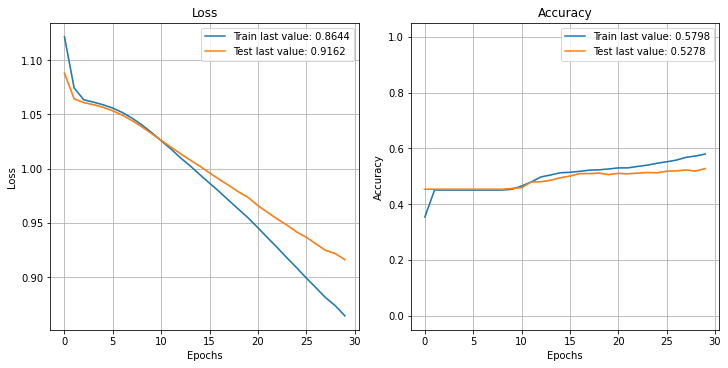

In [ ]:
from plot_keras_history import plot_history
import matplotlib.pyplot as plt
plot_history(history.history, path="standard.png")
plt.show()

The accuracy of lab3 model2 in this task is around 46%. If you use the "glorot_uniform" initialization method, the accuracy can reach around 55%.

##  Model 1-2: CNN or LSTM without pre-trained word embeddings

Please try one more model (CNN or LSTM) without pre-trained word embeddings in here:

In [ ]:
LSTM_layer=LSTM(units=100,activation='tanh',return_sequences=False)(target_embedding)

output_layer = Dense(16,kernel_initializer="glorot_uniform",activation = 'sigmoid')(LSTM_layer)
output_layer_1 = Dense(3,kernel_initializer="glorot_uniform",activation = 'softmax')(output_layer)

model7 = Model(inputs=[target_word], outputs=output_layer_1)
model7.compile(loss='categorical_crossentropy', optimizer = 'adam', metrics = ['accuracy'])
model7.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 128)]             0         
                                                                 
 target_embed_layer (Embeddi  (None, 128, 100)         789800    
 ng)                                                             
                                                                 
 lstm_1 (LSTM)               (None, 100)               80400     
                                                                 
 dense_4 (Dense)             (None, 16)                1616      
                                                                 
 dense_5 (Dense)             (None, 3)                 51        
                                                                 
Total params: 871,867
Trainable params: 871,867
Non-trainable params: 0
_____________________________________________________

In [ ]:
history = model7.fit(x_train_pad,
                    y_train,
                    epochs=30,
                    batch_size=512,
                    validation_data=(x_dev_pad,y_dev),
                    verbose=1)

Epoch 1/30
22/22 [==============================] - 5s 48ms/step - loss: 1.1264 - accuracy: 0.3935 - val_loss: 1.0685 - val_accuracy: 0.4535
Epoch 2/30
22/22 [==============================] - 1s 23ms/step - loss: 1.0676 - accuracy: 0.4507 - val_loss: 1.0647 - val_accuracy: 0.4535
Epoch 3/30
22/22 [==============================] - 1s 23ms/step - loss: 1.0670 - accuracy: 0.4507 - val_loss: 1.0646 - val_accuracy: 0.4535
Epoch 4/30
22/22 [==============================] - 1s 23ms/step - loss: 1.0668 - accuracy: 0.4507 - val_loss: 1.0645 - val_accuracy: 0.4535
Epoch 5/30
22/22 [==============================] - 1s 23ms/step - loss: 1.0665 - accuracy: 0.4507 - val_loss: 1.0645 - val_accuracy: 0.4535
Epoch 6/30
22/22 [==============================] - 1s 24ms/step - loss: 1.0665 - accuracy: 0.4507 - val_loss: 1.0646 - val_accuracy: 0.4535
Epoch 7/30
22/22 [==============================] - 1s 24ms/step - loss: 1.0666 - accuracy: 0.4507 - val_loss: 1.0649 - val_accuracy: 0.4535
Epoch 8/30
22

In [ ]:
results = model7.evaluate(x_test_pad, y_test)

42/42 [==============================] - 0s 6ms/step - loss: 1.0650 - accuracy: 0.4543


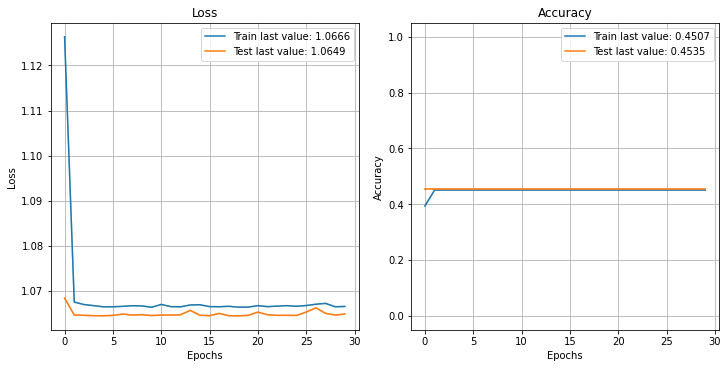

In [ ]:
plot_history(history.history, path="standard.png")
plt.show()

# Model 2: Using pre-trained word embeddings

### Preparing pre-trained word embeddings (GLOVE)

The Embedding layer can be used to load a pre-trained word embedding model. We are going to use GloVe embeddings, which you can read about it here (https://nlp.stanford.edu/projects/glove/). GloVe stands for "Global Vectors for Word Representation". It's a somewhat popular embedding technique based on factorizing a matrix of word co-occurence statistics. You can download GloVe and we can seed the Keras Embedding layer with weights from the pre-trained embedding for the words in your dataset.
First, we need to read GloVe and map words to GloVe:


In [ ]:
def readGloveFile(gloveFile):
    with open(gloveFile, 'r') as f:
        wordToGlove = {}  
        wordToIndex = {}  
        indexToWord = {}  

        for line in f:
            record = line.strip().split()
            token = record[0] 
            wordToGlove[token] = np.array(record[1:], dtype=np.float64) 
            
        tokens = sorted(wordToGlove.keys())
        for idx, tok in enumerate(tokens):
            kerasIdx = idx + 1  
            wordToIndex[tok] = kerasIdx 
            indexToWord[kerasIdx] = tok 

    return wordToIndex, indexToWord, wordToGlove

Now, we create our pre-trained Embedding layer:

In [ ]:
from keras.initializers import Constant

def createPretrainedEmbeddingLayer(wordToGlove, wordToIndex, isTrainable):
    vocabLen = len(wordToIndex) + 1  
    embDim = next(iter(wordToGlove.values())).shape[0]  
   
    embeddingMatrix = np.zeros((vocabLen, embDim))  
    for word, index in wordToIndex.items():
        embeddingMatrix[index, :] = wordToGlove[word] 

    embeddingLayer = Embedding(vocabLen, embDim, embeddings_initializer=Constant(embeddingMatrix), trainable=isTrainable, name='GloVe_Embeddings')
    return embeddingLayer

In [ ]:
!wget http://nlp.stanford.edu/data/glove.6B.zip
!unzip '/content/glove.6B.zip'

--2022-03-14 19:38:46--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2022-03-14 19:38:46--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2022-03-14 19:38:47--  http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip’

glove.6

We freeze the weights. To create the model: 

In [ ]:
# wordToIndex,indexToWord,wordToGlove=readGloveFile('/content/glove.6B.50d.txt')
# wordToIndex,indexToWord,wordToGlove=readGloveFile('/content/glove.6B.100d.txt')
wordToIndex,indexToWord,wordToGlove=readGloveFile('/content/glove.6B.300d.txt')

# vocabLen = len(wordToIndex) + 1 

EMBED_SIZE = next(iter(wordToGlove.values())).shape[0]
print('Size of Embedding: ',EMBED_SIZE)

embeddingLayer=createPretrainedEmbeddingLayer(wordToGlove,wordToIndex,isTrainable=False)

Size of Embedding:  300


In [ ]:
len(wordToIndex)

400000

### Convert the data to GLOVE word index

The index in our vocabulary is different from that in GLOVE. For example, the word "you" corresponds to 394475 in GLOVE, while it corresponds to another index in our vocabulary. Thus we can not directly use the index data in the last section. We convert them from text tokens to GLOVE word index.

In [ ]:
print(wordToIndex["you"])
print(indexToWord[394475])
print(word_index["you"])

394475
you
7714


In [ ]:
wordToIndex["you"]

394475

In [ ]:
# Existing data structure

# Create a new dictionary with "I like py" at the start, then
# everything from the old data structure.
wordToIndex_new = {"<PAD>": 0,"<START>": 1,"<UNK>":2,"<EOS>":3 }
wordToIndex_new.update(wordToIndex)

# new_dictionary is now:
# {'i like py': 'image1.png', 'hello': 'image3.png'}

In [ ]:

x_train_review_glove=[]
i=0
for i in range(len(train)):
  x_train_review_glove.append(tf.keras.preprocessing.text.text_to_word_sequence(train[i][0])) #for train review glove

x_train_aspect_glove=[]
i=0
for i in range(len(train)):
  x_train_aspect_glove.append(tf.keras.preprocessing.text.text_to_word_sequence(train[i][1])) #for train aspect glove


x_train_review_glove_int= copy.deepcopy(x_train_review_glove)

for list1 in x_train_review_glove_int:
  for i in list1:
    if i in wordToIndex_new.keys():
      index = list1.index(i)
      list1[index]=wordToIndex_new.get(i) 
    else:
      index = list1.index(i) #get the index of each word
      list1[index]='<UNK>'#if not in wordToIndex_new replace it with <UNK>
      list1[index]=wordToIndex_new.get(list1[index])  #reolace each word with integer present in wordToIndex_new dictionary



x_train_aspect_glove_int= copy.deepcopy(x_train_aspect_glove) #similar for aspect

for list1 in x_train_aspect_glove_int:
  for i in list1:
    if i in wordToIndex_new.keys():
      index = list1.index(i)
      list1[index]=wordToIndex_new.get(i) 
    else:
      index = list1.index(i)
      list1[index]='<UNK>'
      list1[index]=wordToIndex_new.get(list1[index]) 

In [ ]:
x_test_review_glove=[]
i=0
for i in range(len(test)):
  x_test_review_glove.append(tf.keras.preprocessing.text.text_to_word_sequence(test[i][0]))

x_test_aspect_glove=[]
i=0
for i in range(len(test)):
  x_test_aspect_glove.append(tf.keras.preprocessing.text.text_to_word_sequence(test[i][1]))


x_test_review_glove_int= copy.deepcopy(x_test_review_glove)

for list1 in x_test_review_glove_int:
  for i in list1:
    if i in wordToIndex_new.keys():
      index = list1.index(i)
      list1[index]=wordToIndex_new.get(i) 
    else:
      index = list1.index(i)
      list1[index]='<UNK>'
      list1[index]=wordToIndex_new.get(list1[index]) 


x_test_aspect_glove_int= copy.deepcopy(x_test_aspect_glove)

for list1 in x_test_aspect_glove_int:
  for i in list1:
    if i in wordToIndex_new.keys():
      index = list1.index(i)
      list1[index]=wordToIndex_new.get(i) 
    else:
      index = list1.index(i)
      list1[index]='<UNK>'
      list1[index]=wordToIndex_new.get(list1[index]) 

In [ ]:
x_dev_review_glove=[]
i=0
for i in range(len(val)):
  x_dev_review_glove.append(tf.keras.preprocessing.text.text_to_word_sequence(val[i][0]))

x_dev_aspect_glove=[]
i=0
for i in range(len(val)):
  x_dev_aspect_glove.append(tf.keras.preprocessing.text.text_to_word_sequence(val[i][1]))


x_dev_review_glove_int= copy.deepcopy(x_dev_review_glove)

for list1 in x_dev_review_glove_int:
  for i in list1:
    if i in wordToIndex_new.keys():
      index = list1.index(i)
      list1[index]=wordToIndex_new.get(i) 
    else:
      index = list1.index(i)
      list1[index]='<UNK>'
      list1[index]=wordToIndex_new.get(list1[index]) 


x_dev_aspect_glove_int= copy.deepcopy(x_dev_aspect_glove)

for list1 in x_dev_aspect_glove_int:
  for i in list1:
    if i in wordToIndex_new.keys():
      index = list1.index(i)
      list1[index]=wordToIndex_new.get(i) 
    else:
      index = list1.index(i)
      list1[index]='<UNK>'
      list1[index]=wordToIndex_new.get(list1[index]) 

In [ ]:
assert len(x_train_review_glove) == len(train)
assert len(x_train_aspect_glove) == len(x_train_aspect_int)
assert len(x_test_review_glove) == len(test)
assert len(x_test_aspect_glove) == len(x_test_aspect_int)
print("x_train_review_glove[0]:")
print(x_train_review_glove[0])
print("x_train_aspect_glove[0]:")
print(x_train_aspect_glove[0])

x_train_review_glove[0]:
['the', 'decor', 'is', 'not', 'special', 'at', 'all', 'but', 'their', 'food', 'and', 'amazing', 'prices', 'make', 'up', 'for', 'it']
x_train_aspect_glove[0]:
['decor']


In [ ]:
x_train_review_glove=x_train_review_glove_int
x_train_aspect_glove=x_train_aspect_glove_int
x_test_review_glove=x_test_review_glove_int
x_test_aspect_glove=x_test_aspect_glove_int
x_dev_review_glove=x_dev_review_glove_int
x_dev_aspect_glove=x_dev_aspect_glove_int

In [ ]:
assert len(x_train_review_glove) == len(train)
assert len(x_train_aspect_glove) == len(x_train_aspect_int)
assert len(x_test_review_glove) == len(test)
assert len(x_test_aspect_glove) == len(x_test_aspect_int)
print("x_train_review_glove[0]:")
print(x_train_review_glove[0])
print("x_train_aspect_glove[0]:")
print(x_train_aspect_glove[0])

x_train_review_glove[0]:
[357266, 118926, 192973, 264550, 338995, 62065, 51582, 87775, 357354, 151204, 54718, 53201, 292136, 231458, 373317, 151349, 193716]
x_train_aspect_glove[0]:
[118926]


As before, we concatenate the tweets and topics for fitting in the previous model. Let us do it again for GLOVE version variables.

In [ ]:
def combine_x(x_train_aspect_glove,x_train_review_glove):
  x_train_review_start= copy.deepcopy(x_train_review_glove)
  for list1 in x_train_review_start:
    list1.insert(0,1)

  x_train_glove=[]
  for i in range(len(x_train_review_glove)):
    x_train_glove.append(x_train_aspect_glove[i] + x_train_review_start[i])

  return x_train_glove

In [ ]:
# Please write your code to combine the x_*_review_glove and x_*_aspect_glove into the following varibles
# x_train_glove
# x_dev_glove
# x_test_glove

# Tips: 
# 1) There is no <START> token in GLOVE. Here we can use integer 1 to concatenate.
# 2) After combine them, do not foget to pad the sequences.

#######################TODO: REMOVE FOLLOWING CODE####################

x_train_glove = combine_x(x_train_aspect_glove,x_train_review_glove)
x_dev_glove   = combine_x(x_dev_aspect_glove  ,x_dev_review_glove)
x_test_glove  = combine_x(x_test_aspect_glove ,x_test_review_glove)


x_train_pad_glove = keras.preprocessing.sequence.pad_sequences(x_train_glove,
                                                        value=0,
                                                        padding='post',
                                                        maxlen=128)

x_dev_pad_glove = keras.preprocessing.sequence.pad_sequences(x_dev_glove,
                                                       value=0,
                                                       padding='post',
                                                       maxlen=128)

x_test_pad_glove = keras.preprocessing.sequence.pad_sequences(x_test_glove,
                                                       value=0,
                                                       padding='post',
                                                       maxlen=128)
x_train_pad_glove = np.array(x_train_pad_glove)
x_dev_pad_glove = np.array(x_dev_pad_glove)
x_test_pad_glove = np.array(x_test_pad_glove)
#######################TODO: REMOVE ABOVE CODE####################

# Don't forget the to use np.array function to wrap the ouput of pad_sequences function, such as: x_train_pad = np.array(x_train_pad)
# Only pad the *_int varibles
print("Before paded:")
print(x_train_glove[0])
print("After paded:")
print(x_train_pad_glove[0])

Before paded:
[118926, 1, 357266, 118926, 192973, 264550, 338995, 62065, 51582, 87775, 357354, 151204, 54718, 53201, 292136, 231458, 373317, 151349, 193716]
After paded:
[118926      1 357266 118926 192973 264550 338995  62065  51582  87775
 357354 151204  54718  53201 292136 231458 373317 151349 193716      0
      0      0      0      0      0      0      0      0      0      0
      0      0      0      0      0      0      0      0      0      0
      0      0      0      0      0      0      0      0      0      0
      0      0      0      0      0      0      0      0      0      0
      0      0      0      0      0      0      0      0      0      0
      0      0      0      0      0      0      0      0      0      0
      0      0      0      0      0      0      0      0      0      0
      0      0      0      0      0      0      0      0      0      0
      0      0      0      0      0      0      0      0      0      0
      0      0      0      0      0      0      0

## Model 2-1: Neural bag of words using pre-trained word embeddings

We use model3-1 in lab4 to deal with this task.

In [ ]:
tf.keras.backend.clear_session()

In [ ]:

import tensorflow as tf
from keras.models import Model

embeddingLayer=createPretrainedEmbeddingLayer(wordToGlove,wordToIndex,isTrainable=True)(target_word)
model_second=GlobalAveragePooling1DMasked()(embeddingLayer)

output_layer = Dense(16,activation = 'relu')(model_second)
output_layer_1 = Dense(3,activation = 'softmax')(output_layer)

model3 = Model(inputs=[target_word], outputs=output_layer_1)
model3.compile(loss='categorical_crossentropy', optimizer = 'adam', metrics = ['accuracy'])
model3.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 128)]             0         
                                                                 
 GloVe_Embeddings (Embedding  (None, 128, 300)         120000300 
 )                                                               
                                                                 
 global_average_pooling1d_ma  (None, 300)              0         
 sked_2 (GlobalAveragePoolin                                     
 g1DMasked)                                                      
                                                                 
 dense_6 (Dense)             (None, 16)                4816      
                                                                 
 dense_7 (Dense)             (None, 3)                 51        
                                                           

In [ ]:
history = model3.fit(x_train_pad_glove,
                    y_train,
                    epochs=20,
                    batch_size=512,
                    validation_data=(x_dev_pad_glove,y_dev),
                    verbose=1)

Epoch 1/20
22/22 [==============================] - 2s 76ms/step - loss: 1.0993 - accuracy: 0.3633 - val_loss: 1.0866 - val_accuracy: 0.4174
Epoch 2/20
22/22 [==============================] - 2s 69ms/step - loss: 1.0783 - accuracy: 0.4283 - val_loss: 1.0659 - val_accuracy: 0.4520
Epoch 3/20
22/22 [==============================] - 2s 69ms/step - loss: 1.0562 - accuracy: 0.4445 - val_loss: 1.0422 - val_accuracy: 0.4542
Epoch 4/20
22/22 [==============================] - 2s 70ms/step - loss: 1.0336 - accuracy: 0.4478 - val_loss: 1.0238 - val_accuracy: 0.4550
Epoch 5/20
22/22 [==============================] - 2s 69ms/step - loss: 1.0177 - accuracy: 0.4483 - val_loss: 1.0120 - val_accuracy: 0.4557
Epoch 6/20
22/22 [==============================] - 2s 69ms/step - loss: 1.0051 - accuracy: 0.4532 - val_loss: 0.9998 - val_accuracy: 0.4520
Epoch 7/20
22/22 [==============================] - 2s 70ms/step - loss: 0.9923 - accuracy: 0.4599 - val_loss: 0.9905 - val_accuracy: 0.4692
Epoch 8/20
22

In [ ]:
results=model3.evaluate(x_test_pad_glove,y_test)

42/42 [==============================] - 0s 2ms/step - loss: 0.8847 - accuracy: 0.5808


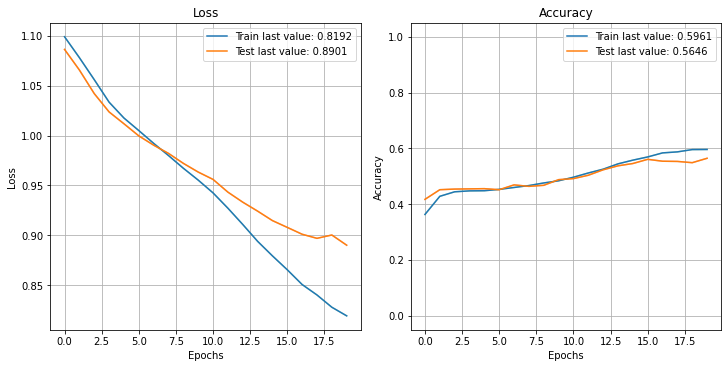

In [ ]:
plot_history(history.history, path="standard.png")
plt.show()

The accuracy is around 56%. In this version, the "glorot_uniform" initialization method does not improve model performance significantly.

##  Model 2-2: CNN or LSTM with pre-trained word embeddings

Please try one more model (CNN or LSTM) with pre-trained word embeddings in here:

In [ ]:
embeddingLayer=createPretrainedEmbeddingLayer(wordToGlove,wordToIndex,isTrainable=True)(target_word)

LSTM_layer=LSTM(units=100,activation='tanh',return_sequences=False)(embeddingLayer)

output_layer = Dense(16,activation = 'relu')(LSTM_layer)
output_layer_1 = Dense(3,activation = 'softmax')(output_layer)

model7 = Model(inputs=[target_word], outputs=output_layer_1)
model7.compile(loss='categorical_crossentropy', optimizer = 'adam', metrics = ['accuracy'])
model7.summary()

Model: "model_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 128)]             0         
                                                                 
 GloVe_Embeddings (Embedding  (None, 128, 300)         120000300 
 )                                                               
                                                                 
 lstm_3 (LSTM)               (None, 100)               160400    
                                                                 
 dense_12 (Dense)            (None, 16)                1616      
                                                                 
 dense_13 (Dense)            (None, 3)                 51        
                                                                 
Total params: 120,162,367
Trainable params: 120,162,367
Non-trainable params: 0
_____________________________________________

In [ ]:
history = model7.fit(x_train_pad_glove,
                    y_train,
                    epochs=40,
                    batch_size=512,
                    validation_data=(x_dev_pad_glove, y_dev),
                    verbose=1)

Epoch 1/40
22/22 [==============================] - 4s 113ms/step - loss: 1.0715 - accuracy: 0.4468 - val_loss: 1.0645 - val_accuracy: 0.4535
Epoch 2/40
22/22 [==============================] - 2s 92ms/step - loss: 1.0668 - accuracy: 0.4507 - val_loss: 1.0648 - val_accuracy: 0.4535
Epoch 3/40
22/22 [==============================] - 2s 92ms/step - loss: 1.0673 - accuracy: 0.4507 - val_loss: 1.0651 - val_accuracy: 0.4535
Epoch 4/40
22/22 [==============================] - 2s 92ms/step - loss: 1.0675 - accuracy: 0.4507 - val_loss: 1.0648 - val_accuracy: 0.4535
Epoch 5/40
22/22 [==============================] - 2s 92ms/step - loss: 1.0667 - accuracy: 0.4507 - val_loss: 1.0650 - val_accuracy: 0.4535
Epoch 6/40
22/22 [==============================] - 2s 92ms/step - loss: 1.0665 - accuracy: 0.4507 - val_loss: 1.0645 - val_accuracy: 0.4535
Epoch 7/40
22/22 [==============================] - 2s 92ms/step - loss: 1.0665 - accuracy: 0.4507 - val_loss: 1.0652 - val_accuracy: 0.4535
Epoch 8/40
2

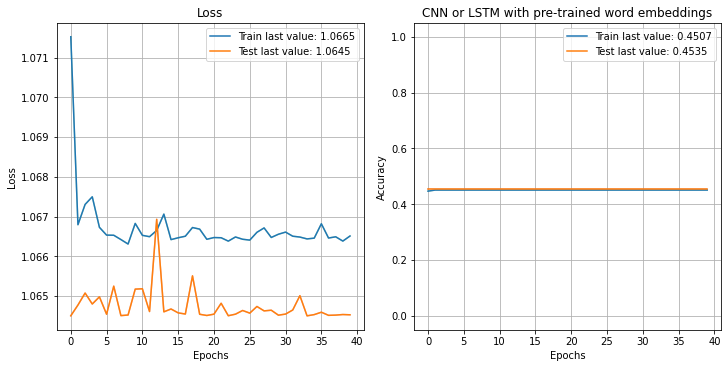

In [ ]:
plot_history(history.history, path="standard.png")
plt.title("CNN or LSTM with pre-trained word embeddings")
plt.show()

#  Model 3: Model with multiple-input

Model 1 and 2 are copied from lab4. We build new models in this section. 

In models 1 and 2, we combine the reviews and aspects to input into the models. In model 3, we separately input these two data into the model and use different layers to analyze them. 

(This will give us a model similar to a simplified version of the Xue & Li model from the lectures - we have a separate paths through the network for the aspect embedding and the sentence, being combined - but we don't have to use gating like Xue & Li).

In [ ]:
# First of all, pad the review and aspect separately
x_train_review_pad_glove = keras.preprocessing.sequence.pad_sequences(x_train_review_glove,
                                                        value=0,
                                                        padding='post',
                                                        maxlen=128)

x_dev_review_pad_glove = keras.preprocessing.sequence.pad_sequences(x_dev_review_glove,
                                                       value=0,
                                                       padding='post',
                                                       maxlen=128)

x_test_review_pad_glove = keras.preprocessing.sequence.pad_sequences(x_test_review_glove,
                                                       value=0,
                                                       padding='post',
                                                       maxlen=128)

x_train_aspect_pad_glove = keras.preprocessing.sequence.pad_sequences(x_train_aspect_glove,
                                                        value=0,
                                                        padding='post',
                                                        maxlen=16)

x_dev_aspect_pad_glove = keras.preprocessing.sequence.pad_sequences(x_dev_aspect_glove,
                                                       value=0,
                                                       padding='post',
                                                       maxlen=16)

x_test_aspect_pad_glove = keras.preprocessing.sequence.pad_sequences(x_test_aspect_glove,
                                                       value=0,
                                                       padding='post',
                                                       maxlen=16)

## Model 3-1 Neural bag of words model with multiple-input

Model 3-1 needs you to modify the model 2-1 to be compatible with multiple-input.
You could find some tutorial examples from (https://www.pyimagesearch.com/2019/02/04/keras-multiple-inputs-and-mixed-data/).

Please print the model summary and visualize it using vis_utils.

In [ ]:
target_word = Input((16,), dtype='int32')
target_word_1 = Input((128,), dtype='int32')

In [ ]:
embeddingLayer=createPretrainedEmbeddingLayer(wordToGlove,wordToIndex,isTrainable=False)
embeddings=embeddingLayer(target_word)

model_second=GlobalAveragePooling1DMasked()(embeddings)
embeddings_1=embeddingLayer(target_word_1)
model_third=GlobalAveragePooling1DMasked()(embeddings_1)

output_layer = Dense(16)(model_second)
output_layer_1 = Dense(16)(model_third)

concatted = tf.keras.layers.Concatenate()([output_layer, output_layer_1])

output=Dense(3,activation="softmax")(concatted)

model4 = Model(inputs=[target_word,target_word_1], outputs=output)
model4.compile(loss='categorical_crossentropy', optimizer = 'adam', metrics = ['accuracy'])
model4.summary()

Model: "model_7"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 16)]         0           []                               
                                                                                                  
 input_2 (InputLayer)           [(None, 128)]        0           []                               
                                                                                                  
 GloVe_Embeddings (Embedding)   multiple             120000300   ['input_1[0][0]',                
                                                                  'input_2[0][0]']                
                                                                                                  
 global_average_pooling1d_maske  (None, 300)         0           ['GloVe_Embeddings[0][0]'] 

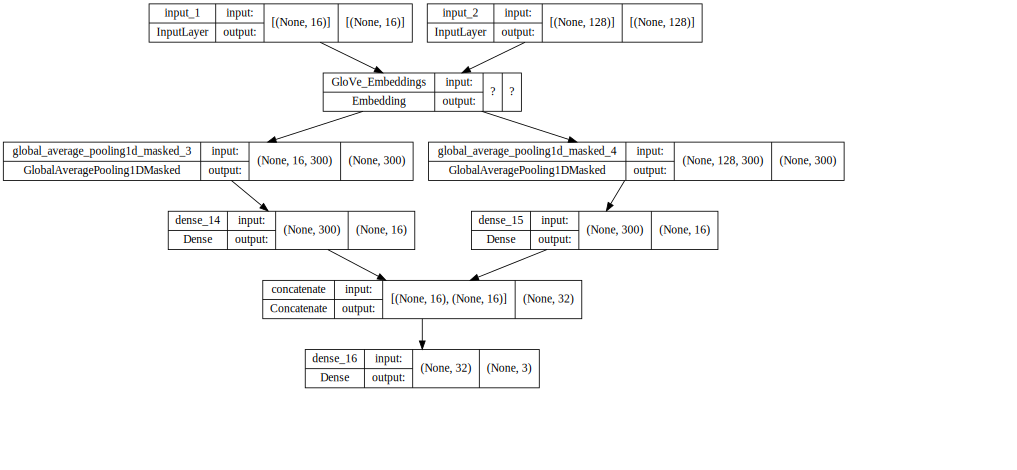

In [ ]:
from IPython.display import SVG
from keras.utils import vis_utils
SVG(vis_utils.model_to_dot(model4, show_shapes=True, show_layer_names=True, dpi=60).create(prog='dot', format='svg'))  

Train and evaluate your model:

In [ ]:
history = model4.fit([x_train_aspect_pad_glove,x_train_review_pad_glove],
                    y_train,
                    epochs=40,
                    batch_size=512,
                    validation_data=([x_dev_aspect_pad_glove,x_dev_review_pad_glove],y_dev),
                    verbose=1)

Epoch 1/40
22/22 [==============================] - 1s 11ms/step - loss: 1.0628 - accuracy: 0.4452 - val_loss: 1.0359 - val_accuracy: 0.4535
Epoch 2/40
22/22 [==============================] - 0s 5ms/step - loss: 1.0248 - accuracy: 0.4511 - val_loss: 1.0015 - val_accuracy: 0.4550
Epoch 3/40
22/22 [==============================] - 0s 5ms/step - loss: 0.9931 - accuracy: 0.4779 - val_loss: 0.9689 - val_accuracy: 0.5195
Epoch 4/40
22/22 [==============================] - 0s 5ms/step - loss: 0.9635 - accuracy: 0.5426 - val_loss: 0.9406 - val_accuracy: 0.5526
Epoch 5/40
22/22 [==============================] - 0s 5ms/step - loss: 0.9374 - accuracy: 0.5654 - val_loss: 0.9160 - val_accuracy: 0.5863
Epoch 6/40
22/22 [==============================] - 0s 5ms/step - loss: 0.9161 - accuracy: 0.5839 - val_loss: 0.8952 - val_accuracy: 0.5893
Epoch 7/40
22/22 [==============================] - 0s 5ms/step - loss: 0.8983 - accuracy: 0.5897 - val_loss: 0.8798 - val_accuracy: 0.5946
Epoch 8/40
22/22 [=

In [ ]:
results = model4.evaluate([x_test_aspect_pad_glove,x_test_review_pad_glove],y_test)
print(results)

42/42 [==============================] - 0s 2ms/step - loss: 0.7752 - accuracy: 0.6609
[0.7751774787902832, 0.6609281301498413]


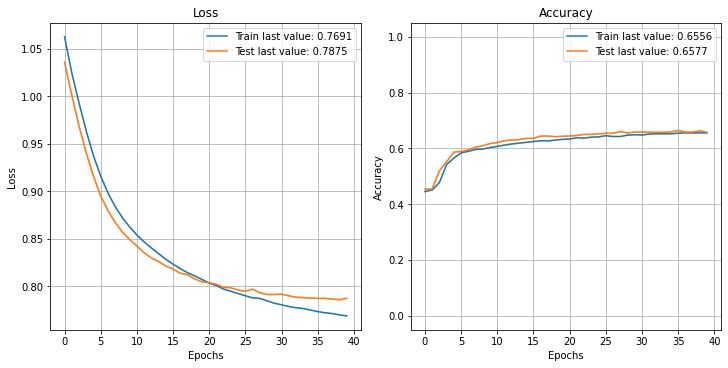

In [ ]:
plot_history(history.history, path="standard.png")
plt.show()

## Model 3-2 CNN or LSTM model with multiple-input

Modify the previous CNN or LSTM model to be compatible with multiple-input, similar to model 3-1. 

In [ ]:
target_word = Input((16,), dtype='int32')
target_word_1 = Input((128,), dtype='int32')

embeddingLayer=createPretrainedEmbeddingLayer(wordToGlove,wordToIndex,isTrainable=False)
embeddings=embeddingLayer(target_word)

LSTM_layer=LSTM(units=100,activation='tanh',return_sequences=False)(embeddings)
embeddings_1=embeddingLayer(target_word_1)
LSTM_layer_1=LSTM(units=100,activation='tanh',return_sequences=False)(embeddings_1)

output_layer = Dense(16)(LSTM_layer)
output_layer_1 = Dense(16)(LSTM_layer_1)

concatted = tf.keras.layers.Concatenate()([output_layer, output_layer_1])

output=Dense(3,activation="softmax")(concatted)

model5 = Model(inputs=[target_word,target_word_1], outputs=output)
model5.compile(loss='categorical_crossentropy', optimizer = 'adam', metrics = ['accuracy'])
model5.summary()

Model: "model_8"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 16)]         0           []                               
                                                                                                  
 input_4 (InputLayer)           [(None, 128)]        0           []                               
                                                                                                  
 GloVe_Embeddings (Embedding)   multiple             120000300   ['input_3[0][0]',                
                                                                  'input_4[0][0]']                
                                                                                                  
 lstm_4 (LSTM)                  (None, 100)          160400      ['GloVe_Embeddings[0][0]'] 

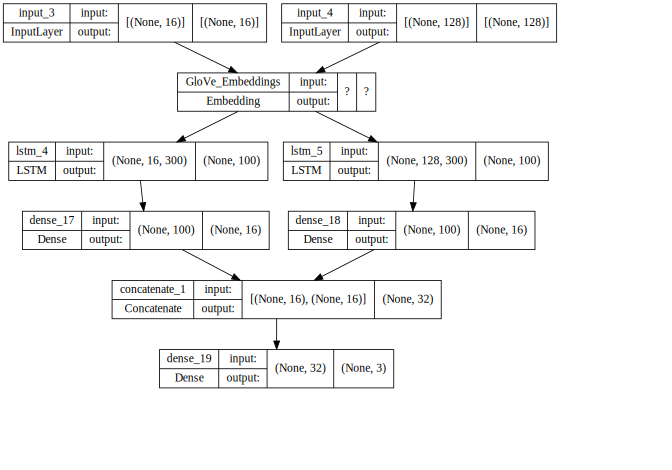

In [ ]:
from IPython.display import SVG
from keras.utils import vis_utils
SVG(vis_utils.model_to_dot(model5, show_shapes=True, show_layer_names=True, dpi=60).create(prog='dot', format='svg'))

In [ ]:
history = model5.fit([x_train_aspect_pad_glove,x_train_review_pad_glove],
                    y_train,
                    epochs=40,
                    batch_size=512,
                    validation_data=([x_dev_aspect_pad_glove,x_dev_review_pad_glove],y_dev),
                    verbose=1)

Epoch 1/40
22/22 [==============================] - 5s 74ms/step - loss: 1.0196 - accuracy: 0.4775 - val_loss: 0.9055 - val_accuracy: 0.5968
Epoch 2/40
22/22 [==============================] - 1s 36ms/step - loss: 0.8903 - accuracy: 0.5837 - val_loss: 0.8519 - val_accuracy: 0.6074
Epoch 3/40
22/22 [==============================] - 1s 37ms/step - loss: 0.8617 - accuracy: 0.6029 - val_loss: 0.8404 - val_accuracy: 0.6066
Epoch 4/40
22/22 [==============================] - 1s 37ms/step - loss: 0.8518 - accuracy: 0.6106 - val_loss: 0.8373 - val_accuracy: 0.6171
Epoch 5/40
22/22 [==============================] - 1s 36ms/step - loss: 0.8444 - accuracy: 0.6162 - val_loss: 0.8375 - val_accuracy: 0.6209
Epoch 6/40
22/22 [==============================] - 1s 37ms/step - loss: 0.8380 - accuracy: 0.6204 - val_loss: 0.8318 - val_accuracy: 0.6246
Epoch 7/40
22/22 [==============================] - 1s 37ms/step - loss: 0.8318 - accuracy: 0.6238 - val_loss: 0.8370 - val_accuracy: 0.6291
Epoch 8/40
22

In [ ]:
results = model5.evaluate([x_test_aspect_pad_glove,x_test_review_pad_glove],y_test) 
print(results)

42/42 [==============================] - 0s 7ms/step - loss: 1.0784 - accuracy: 0.6040
[1.0783694982528687, 0.6040419340133667]


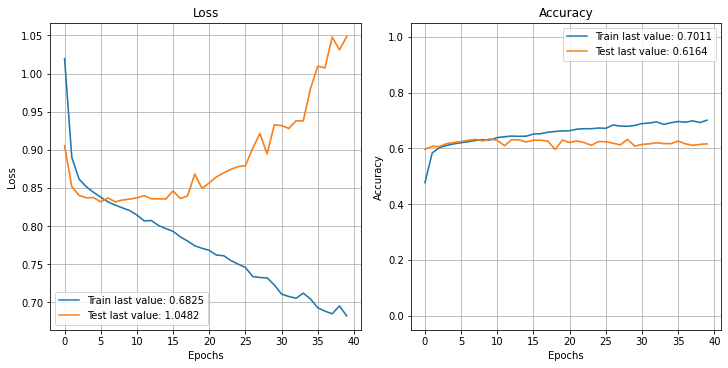

In [ ]:
plot_history(history.history, path="standard.png")
plt.show()

#  Model 4: Another LSTM model

If you study the data carefully, you can find that every aspect appears in the review sentence, which means we can extract the aspect information from the sentence. In most cases, the polarity of the aspect is determined by the content near it. Therefore, an LSTM can transfer the information of adjacent context to the aspect. We only need to extract the aspect vector to calculate its polarity, without analyzing the whole sentence.

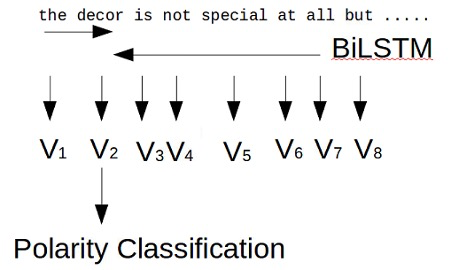

(This is a bit like a simplified version of the "unknown target" sequence tagging models discussed in lectures - but we're only trying to tag the one part of the sequence that we know corresponds to the aspect mention.)

In [ ]:
def aspect_mask(reviews, aspects, dataset):
  mask = []
  for review,aspect,data in zip(reviews, aspects, dataset):
    find_aspect = False
    for j in range(5):
      aspect_num = len(aspect)
      aspect_str = " ".join(aspect)
      aspect_len = int(len(aspect_str) - 1) * (j+1)
      offset = 0
      for i,r in enumerate(review):
        if i + aspect_num <= len(review):
          r_context = " ".join(review[i:i+aspect_num])
          if r_context == aspect_str and offset + aspect_len >  int(data[3]) and offset + aspect_len <  int(data[4]):
            find_aspect = True
            sentence_mask = [0] * len(review)
            sentence_mask[i:i+aspect_num] = [1] * aspect_num
            mask.append(sentence_mask)
            break
          else:
            offset += (len(r) + 1)
      if find_aspect:
        break

    if not find_aspect:
      for j in range(5):
        aspect_len = int(len(aspect_str) - 1) * (j+1)
        offset = 0
        for i,r in enumerate(review):
          if i + aspect_num <= len(review):
            r_context = " ".join(review[i:i+aspect_num])
            if r_context.startswith(aspect_str) and offset + aspect_len >  int(data[3]) and offset + aspect_len <  int(data[4]):
              find_aspect = True
              sentence_mask = [0] * len(review)
              sentence_mask[i:i+aspect_num] = [1] * aspect_num
              mask.append(sentence_mask)
              break
            else:
              offset += (len(r) + 1)
        if find_aspect:
          break

    if not find_aspect:
      for j in range(5):
        aspect_len = int(len(aspect_str) - 1) * (j+1)
        offset = 0
        for i,r in enumerate(review):
          if i + aspect_num <= len(review):
            r_context = " ".join(review[i:i+aspect_num])
            if r_context.endswith(aspect_str) and offset + aspect_len >  int(data[3]) and offset + aspect_len <  int(data[4]):
              find_aspect = True
              sentence_mask = [0] * len(review)
              sentence_mask[i:i+aspect_num] = [1] * aspect_num
              mask.append(sentence_mask)
              break
            else:
              offset += (len(r) + 1)
        if find_aspect:
          break

    if not find_aspect:
      print("annotation error:")
      print(data)
      sentence_mask = [0] * len(review)
      sentence_mask[16] = 1
      mask.append(sentence_mask)

    # if aspect_num > 1:
    #   print(mask[-1])

  return mask
x_train_aspect_mask = aspect_mask(x_train_review, x_train_aspect, train)
x_dev_aspect_mask = aspect_mask(x_dev_review, x_dev_aspect, val)
x_test_aspect_mask = aspect_mask(x_test_review, x_test_aspect, test)

print()
print()
print()
assert len(x_train_aspect_mask) == len(train)
assert len(x_test_aspect_mask) == len(x_test_aspect)

print(train[0])
print(x_train_aspect_mask[0])
print(train[1])
print(x_train_aspect_mask[1])
print(train[2])
print(x_train_aspect_mask[2])
print(train[3])
print(x_train_aspect_mask[3])
print(train[10319])
print(x_train_aspect_mask[10319])

annotation error:
['i love the food here, and although it is pricey, the entree comes with rice, naan, dal, and salad, which makes it worthwhile.', 'd al', 'neutral', '24', '28']



['the decor is not special at all but their food and amazing prices make up for it.', 'decor', 'negative', '4', '9']
[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
['the decor is not special at all but their food and amazing prices make up for it.', 'food', 'positive', '42', '46']
[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0]
['the decor is not special at all but their food and amazing prices make up for it.', 'prices', 'positive', '59', '65']
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0]
['when tables opened up, the manager sat another party before us.', 'tables', 'neutral', '5', '11']
[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0]
['the scene there are two distinct personalities to the place: the loud, seemingly always-crowded bar with hanging paper decorations and dim lighting, and the two main dinin

In [ ]:
train[10319]

['the scene there are two distinct personalities to the place: the loud, seemingly always-crowded bar with hanging paper decorations and dim lighting, and the two main dining areas, where the noise level and decor is notably more subdued.',
 'noise level',
 'negative',
 '190',
 '201']

In [ ]:
x_train_aspect_mask_pad = keras.preprocessing.sequence.pad_sequences(x_train_aspect_mask,
                                                        value=0,
                                                        padding='post',
                                                        maxlen=128)
x_dev_aspect_mask_pad = keras.preprocessing.sequence.pad_sequences(x_dev_aspect_mask,
                                                        value=0,
                                                        padding='post',
                                                        maxlen=128)
x_test_aspect_mask_pad = keras.preprocessing.sequence.pad_sequences(x_test_aspect_mask,
                                                        value=0,
                                                        padding='post',
                                                        maxlen=128)
x_train_aspect_mask_pad[0]

array([0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], dtype=int32)

In [ ]:
tf.keras.backend.clear_session()

In [ ]:
target_word = Input((128,), dtype='int32')
embeddingLayer=createPretrainedEmbeddingLayer(wordToGlove,wordToIndex,isTrainable=False)(target_word)

LSTM_layer=Bidirectional(LSTM(100, return_sequences=True),name = 'BiLSTM')(embeddingLayer)
target_word_1 = Input((128,), dtype='float32')
dotted = tf.keras.layers.Dot(axes=1)([LSTM_layer,target_word_1])

hiden_output=Dense(16)(dotted)
output_layer_1 = Dense(3,activation="softmax")(hiden_output)
model6 = Model(inputs=[target_word,target_word_1], outputs=output_layer_1)
model6.compile(loss='categorical_crossentropy', optimizer = 'adam', metrics = ['accuracy'])
model6.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 128)]        0           []                               
                                                                                                  
 GloVe_Embeddings (Embedding)   (None, 128, 300)     120000300   ['input_1[0][0]']                
                                                                                                  
 BiLSTM (Bidirectional)         (None, 128, 200)     320800      ['GloVe_Embeddings[0][0]']       
                                                                                                  
 input_2 (InputLayer)           [(None, 128)]        0           []                               
                                                                                              

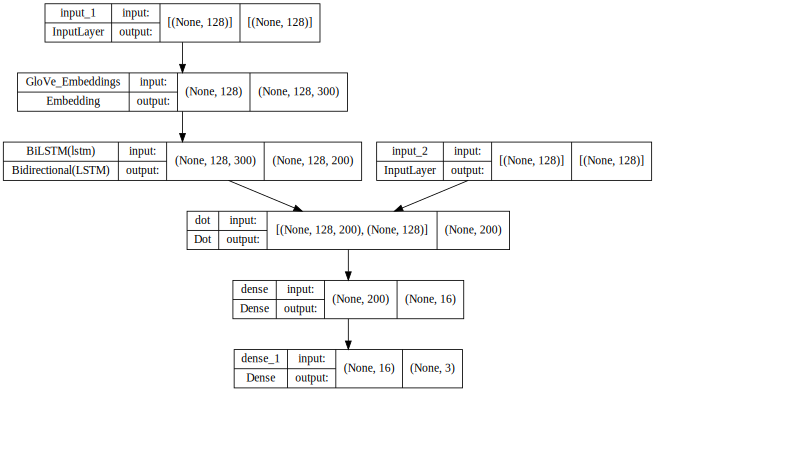

In [ ]:
from IPython.display import SVG
from keras.utils import vis_utils
SVG(vis_utils.model_to_dot(model6, show_shapes=True, show_layer_names=True, dpi=60).create(prog='dot', format='svg'))  

In [ ]:
history = model6.fit([x_train_review_pad_glove,x_train_aspect_mask_pad],
                    y_train,
                    epochs=40,
                    batch_size=512,
                    validation_data=([x_dev_review_pad_glove,x_dev_aspect_mask_pad],y_dev),
                    verbose=1)

Epoch 1/40
22/22 [==============================] - 5s 100ms/step - loss: 0.9390 - accuracy: 0.5646 - val_loss: 0.8196 - val_accuracy: 0.6599
Epoch 2/40
22/22 [==============================] - 1s 64ms/step - loss: 0.7739 - accuracy: 0.6662 - val_loss: 0.7494 - val_accuracy: 0.6892
Epoch 3/40
22/22 [==============================] - 1s 65ms/step - loss: 0.6937 - accuracy: 0.7088 - val_loss: 0.7263 - val_accuracy: 0.6959
Epoch 4/40
22/22 [==============================] - 1s 65ms/step - loss: 0.6374 - accuracy: 0.7385 - val_loss: 0.6820 - val_accuracy: 0.7177
Epoch 5/40
22/22 [==============================] - 1s 65ms/step - loss: 0.5806 - accuracy: 0.7618 - val_loss: 0.6822 - val_accuracy: 0.7312
Epoch 6/40
22/22 [==============================] - 1s 66ms/step - loss: 0.5359 - accuracy: 0.7830 - val_loss: 0.6812 - val_accuracy: 0.7350
Epoch 7/40
22/22 [==============================] - 1s 67ms/step - loss: 0.4994 - accuracy: 0.7987 - val_loss: 0.7002 - val_accuracy: 0.7282
Epoch 8/40
2

In [ ]:
results = model6.evaluate([x_test_review_pad_glove,x_test_aspect_mask_pad],y_test)
print(results)

42/42 [==============================] - 0s 10ms/step - loss: 2.2029 - accuracy: 0.7096
[2.202911138534546, 0.7095808386802673]


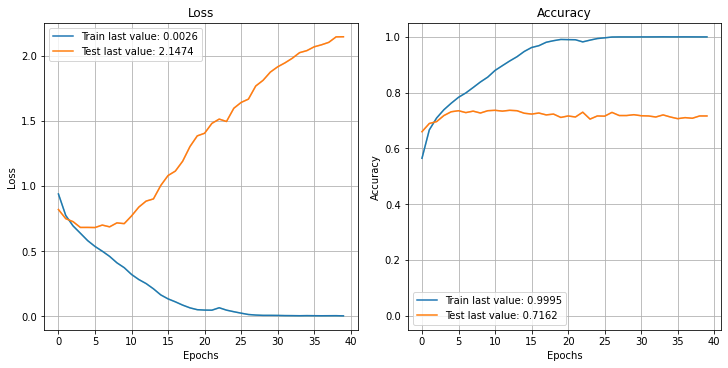

In [ ]:
plot_history(history.history, path="standard.png")
plt.show()